In [4]:
import os
import cv2
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
import os
import pathlib  
from pathlib import Path
from sklearn.model_selection import train_test_split
from keras.metrics import Precision, Recall
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa
from tensorflow_addons import metrics

In [8]:
data_dir='/kaggle/input/computer-aided-gastrointestinal-disease-detection/kvasir-dataset-v2'
rootdir='/kaggle/working/'

In [9]:
def count_files(rootdir):
    '''counts the number of files in each subfolder in a directory'''
    for path in pathlib.Path(rootdir).iterdir():
        if path.is_dir():
            print( str(len([name for name in os.listdir(path) \
            if os.path.isfile(os.path.join(path, name))])) + " files inside the " + \
            str(path.name),'class')
count_files(data_dir)

1000 files inside the dyed-lifted-polyps class
1000 files inside the normal-z-line class
1000 files inside the dyed-resection-margins class
1000 files inside the normal-pylorus class
1000 files inside the normal-cecum class
1000 files inside the polyps class
1000 files inside the ulcerative-colitis class
1000 files inside the esophagitis class


**DATASET PREPARATION**

In [10]:
def d_categories(d_path):
    categories=[]
    for folder_name in os.listdir(d_path):
        if os.path.isdir(os.path.join(d_path,folder_name)):
            no_of_files=len(glob.glob(os.path.join(d_path,folder_name)+ '/*.jpg'))  #pattern matching
            categories.append(np.array([folder_name,no_of_files]))
    categories.sort(key=lambda a: a[0])
    cat=np.array(categories)
    return list(cat[:, 0]),list(cat[:,1])
categories,no_of_files = d_categories(data_dir)
print(categories)

['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis', 'normal-cecum', 'normal-pylorus', 'normal-z-line', 'polyps', 'ulcerative-colitis']


In [11]:
print("number of categories: ", len(categories))

number of categories:  8


In [12]:
df = pd.DataFrame({"category": categories, "number of files": no_of_files})
df

,category,number of files
0,dyed-lifted-polyps,1000
1,dyed-resection-margins,1000
2,esophagitis,1000
3,normal-cecum,1000
4,normal-pylorus,1000
5,normal-z-line,1000
6,polyps,1000
7,ulcerative-colitis,1000


plt.figure(figsize=(16,5))
a=sns.countplot(x=df['category'],data=df,width=0.8,log=False)
plt.show()

In [13]:
def dataset(d_path,categories,iwidth,iheight):
    x,y=[],[]
    for category in categories:
        path=os.path.join(data_dir,category)
        class_id=categories.index(category)   #create unique id's for the 8 different classes.eg: 0,1...
        for img in os.listdir(path):
            img_array=cv2.imread(os.path.join(path,img))
            img_size=cv2.resize(img_array,(iwidth,iheight))  #rgb
            x.append(img_size),y.append(class_id)
    y=np.array(y)   #labels
    x=np.array(x).reshape(y.shape[0],iwidth,iheight,3)  #Gives a new shape to an array without changing its data.
    return x,y
iwidth=100
iheight=100
x,y=dataset(data_dir,categories,iwidth,iheight)
print('process_completed')

process_completed


In [14]:
print(f"x shape: {x.shape}")
print(f"y shape: {y.shape}")

x shape: (8000, 100, 100, 3)
y shape: (8000,)


**CLASS IMAGES**

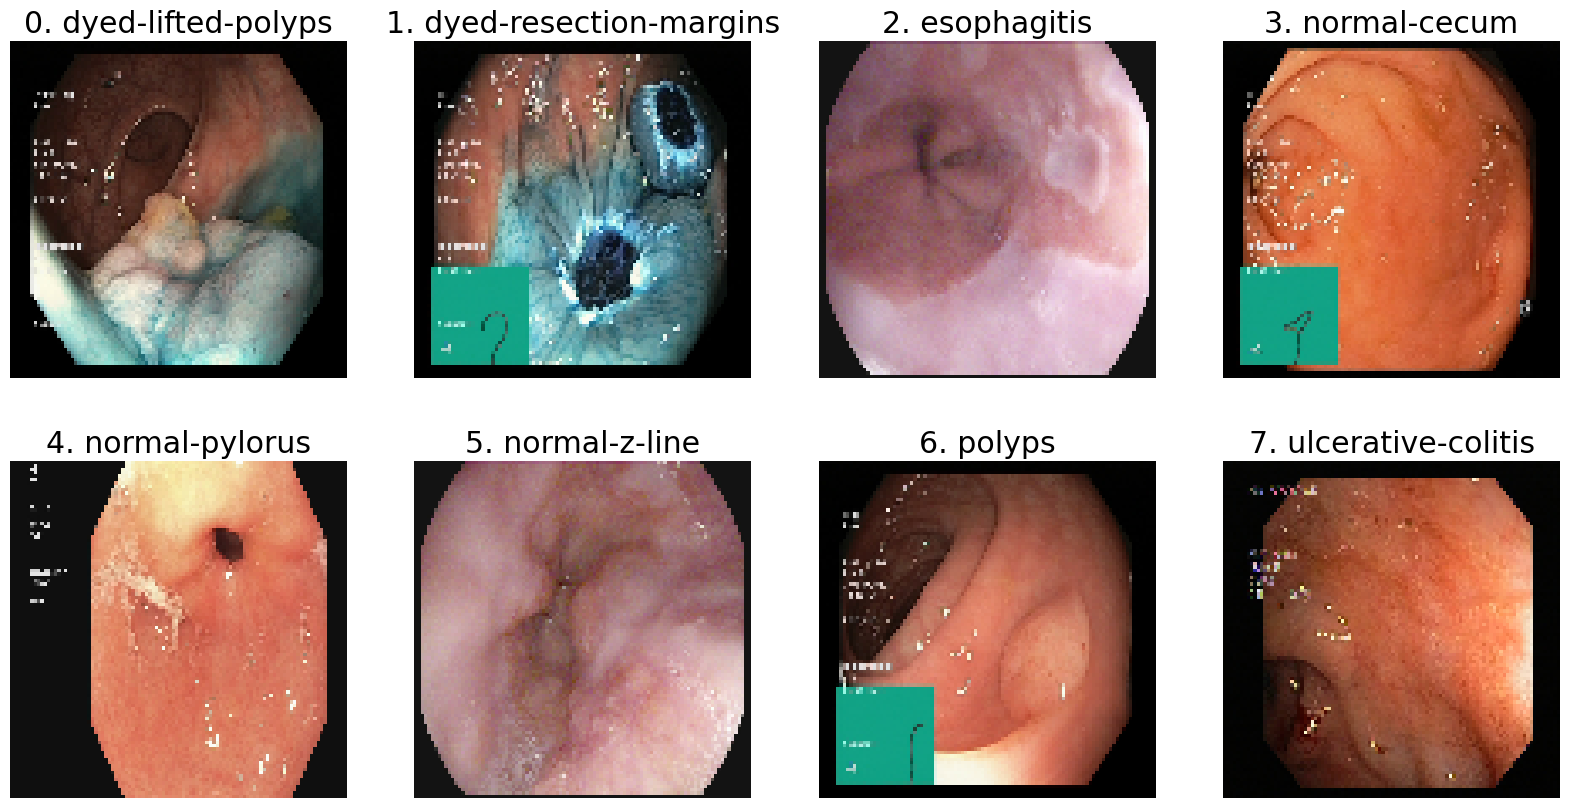

In [17]:
plt.figure(figsize=(20, 10))
st, end = 0, 500
for i in range(8):
    plt.subplot(2, 4, i + 1)
    idx = np.random.randint(st, end)
    st = end + 1
    end = (i + 2) * 1000
    plt.rcParams.update({'font.size':18})
    plt.imshow(x[idx][:, :, ::-1])
    plt.title(f"{i}. {categories[y[idx]]}")
    plt.axis("off")
plt.show()

**SPLITTING OF DATASET INTO TRAIN-VAL-TEST***

In [18]:
y=np.reshape(y,(len(y),1))
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.1,random_state=42)
print(f"x_train: {x_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"x_test: {x_test.shape}")
print(f"y_test: {y_test.shape}")

x_train: (7200, 100, 100, 3)
y_train: (7200, 1)
x_test: (800, 100, 100, 3)
y_test: (800, 1)


In [19]:
#validation -30% from training set
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,train_size=0.75)
x_test=x_test

print(f"x_train:{x_train.shape},y_train:{y_train.shape}")       
print(f"x_val: {x_val.shape},y_val:{y_val.shape}")
print(f"x_test:{x_test.shape},y_test:{y_test.shape}")

x_train:(5400, 100, 100, 3),y_train:(5400, 1)
x_val: (1800, 100, 100, 3),y_val:(1800, 1)
x_test:(800, 100, 100, 3),y_test:(800, 1)


**ONE-HOT ENCODING**

One-Hot Encoding is the process of creating dummy variables.Every unique value in the category will be added as a feature. The categorical feature is not ordinal and the number of categorical features is less so one-hot encoding can be effectively applied

In [20]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

print(f"x_train:{x_train.shape},  y_train:{y_train.shape}")
print(f"x_val:{x_val.shape},  y_val:{y_val.shape}")
print(f"x_test:{x_test.shape},  y_test:{y_test.shape}")

x_train:(5400, 100, 100, 3),  y_train:(5400, 8)
x_val:(1800, 100, 100, 3),  y_val:(1800, 8)
x_test:(800, 100, 100, 3),  y_test:(800, 8)


**IMAGE PREPROCESSING**

In [21]:
train_generator=ImageDataGenerator(rescale=1./255,
                                   rotation_range=2,
                                  horizontal_flip=True,
                                   shear_range=0.5,
                                  zoom_range=0.7)
val_generator=ImageDataGenerator(rescale=1./255,
                                 rotation_range=2,
                                 horizontal_flip=True,
                                 shear_range=0.5,
                                 zoom_range=0.1)
test_generator=ImageDataGenerator(rotation_range=2,
                                 horizontal_flip=True,
                                 zoom_range=0.1)

train_generator.fit(x_train)
val_generator.fit(x_val)
test_generator.fit(x_test)

**USING PRETRAINED MODEL AND  SLIGHT-MODIFICATIONS**

In [22]:
from tensorflow.keras.applications import VGG19
from sklearn.metrics import confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD, Adam
from keras.models import Sequential, load_model
from keras.layers import Flatten, Dense, Dropout

In [156]:
base_model=VGG19(include_top=False,
                weights='imagenet',
                input_shape=(100,100,3),
                classes=8)

In [130]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

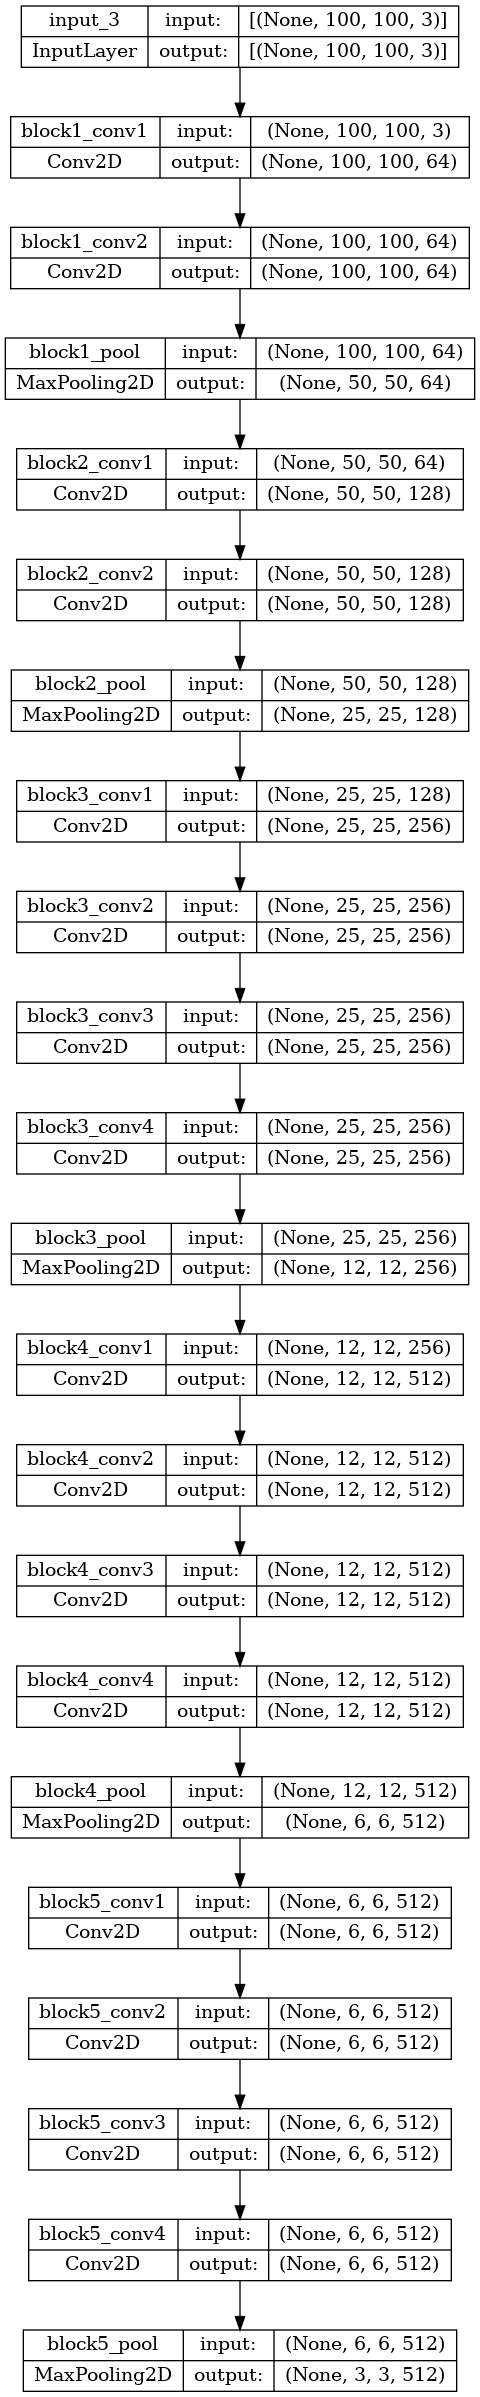

In [36]:
from tensorflow.keras.utils import plot_model
plot_model(base_model,show_shapes=True,to_file = 'vgg19.png')

In [157]:
m=Sequential()
m.add(base_model)
m.add(Flatten())
m.add(Dense(4096,activation='relu'))
m.add(Dense(2048,activation='relu'))#,input_dim=1024))
m.add(Dense(1024,activation='relu'))#,input_dim=512))
m.add(Dense(512,activation='relu'))
m.add(Dense(256,activation='relu'))
m.add(Dropout(0.3)) #0.3
m.add(Dense(128,activation='relu'))
m.add(Dense(y_train.shape[1],activation='softmax'))  #8 outputs

In [38]:
m.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 3, 3, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 4608)              0         
                                                                 
 dense_7 (Dense)             (None, 4096)              18878464  
                                                                 
 dense_8 (Dense)             (None, 2048)              8390656   
                                                                 
 dense_9 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_10 (Dense)            (None, 512)               524800    
                                                                 
 dense_11 (Dense)            (None, 256)              

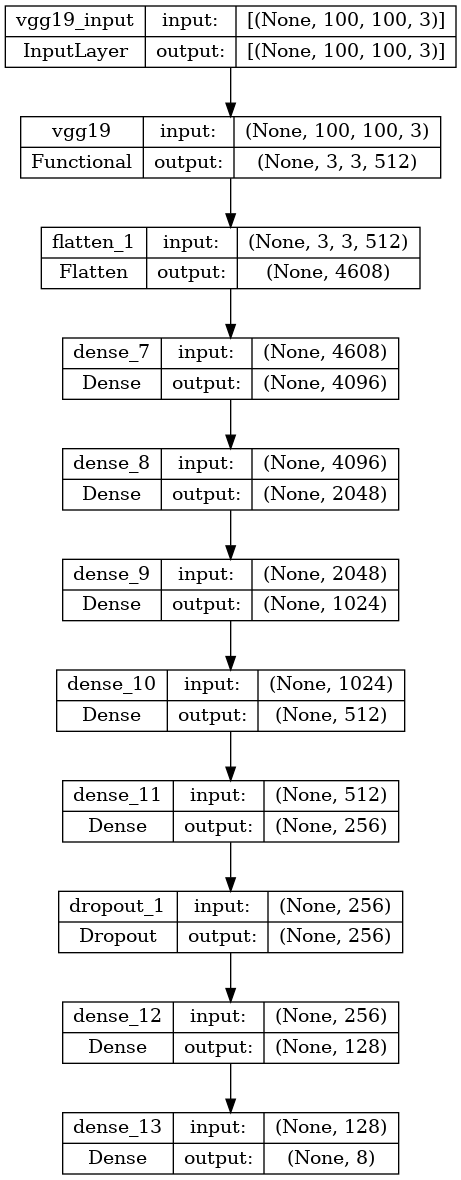

In [39]:
from tensorflow.keras.utils import plot_model
plot_model(m,show_shapes=True,to_file = ' final model vgg19.png')

**INTIALIZING HYPERPARAMETERS OF MODIFIED MODEL**

In [158]:
batch_size=100
epochs=45  #40
learn_rate= 0.001 #0.001
sgd=SGD(learning_rate=learn_rate,
    momentum=0.9,
   nesterov=True)

m.compile(optimizer=sgd,
          loss="categorical_crossentropy",
          metrics=['accuracy',
                   Precision(name="Precision"),
                   Recall(name='Recall')])

In [159]:
m.compile(optimizer=sgd,
          loss="categorical_crossentropy",
          metrics=['accuracy',
                   Precision(name="Precision"),
                   Recall(name='Recall'),tfa.metrics.F1Score(num_classes=8)])
                  

In [160]:
#learning rate annealer
lrr=ReduceLROnPlateau(monitor='val_acc',
                      factor=0.01,
                      patience=5,
                      min_lr="min")

In [161]:
history=m.fit(x_train,y_train,
                 epochs=epochs,
                 steps_per_epoch=200,#200
                 validation_data=val_generator.flow(x_val,y_val,batch_size=batch_size),
                 validation_steps=200, #200
                 callbacks=[lrr],
                 verbose=1)
history=history.history
m.save('/kaggle/working/model1.h5')


Epoch 1/45
200/200 [==============================] - 20s 94ms/step - loss: 1.4816 - accuracy: 0.3587 - Precision: 0.5442 - Recall: 0.1731 - f1_score: 0.3533 - val_loss: 2.3085 - val_accuracy: 0.1306 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_f1_score: 0.0289 - lr: 0.0010
Epoch 2/45
200/200 [==============================] - 14s 68ms/step - loss: 0.7502 - accuracy: 0.6420 - Precision: 0.6693 - Recall: 0.5726 - f1_score: 0.6354 - lr: 0.0010
Epoch 3/45
200/200 [==============================] - 14s 69ms/step - loss: 0.5293 - accuracy: 0.7833 - Precision: 0.8014 - Recall: 0.7600 - f1_score: 0.7816 - lr: 0.0010
Epoch 4/45
200/200 [==============================] - 14s 68ms/step - loss: 0.3927 - accuracy: 0.8446 - Precision: 0.8555 - Recall: 0.8309 - f1_score: 0.8429 - lr: 0.0010
Epoch 5/45
200/200 [==============================] - 14s 68ms/step - loss: 0.3059 - accuracy: 0.8852 - Precision: 0.8918 - Recall: 0.8774 - f1_score: 0.8839 - lr: 0.0010
Epoch 6/45
200/200 [=======

**EVALUATION OF MODEL**

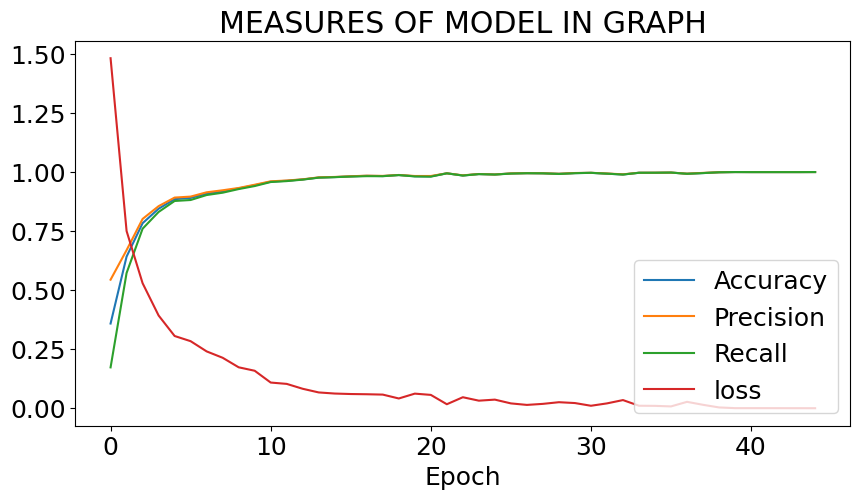

<Figure size 640x480 with 0 Axes>

In [310]:
plt.figure(figsize=(10,5))
plt.plot(history["accuracy"])
plt.plot(history['Precision'])
plt.plot(history['Recall'])
plt.plot(history['loss'])
plt.title('MEASURES OF MODEL IN GRAPH')
plt.xlabel("Epoch")
plt.legend(["Accuracy","Precision","Recall","loss"])
plt.show()
plt.savefig('model graphic measures1.png')
plt.show()

In [231]:
score=m.evaluate(x_test,y_test,verbose=1)
score

25/25 [==============================] - 1s 26ms/step - loss: 0.7474 - accuracy: 0.9087 - Precision: 0.9087 - Recall: 0.9087 - f1_score: 0.9078


[0.7474232316017151,
 0.9087499976158142,
 0.9087499976158142,
 0.9087499976158142,
 array([0.92537314, 0.9396552 , 0.8324873 , 0.9361702 , 0.99476445,
        0.82162166, 0.8969072 , 0.9150944 ], dtype=float32)]

In [212]:
print(f"TEST ACCURACY: {round(score[1]*100,2)}%")
print(f"TEST PRECISSION: {round(score[2]*100,2)}%")
print(f"TEST RECALL: {round(score[3]*100,2)}%")
print(f"TEST F1_SCORE: {(score[4])}")
print(f"TEST loss: {score[0]}")

TEST ACCURACY: 90.87%
TEST PRECISSION: 90.87%
TEST RECALL: 90.87%
TEST F1_SCORE: [0.92537314 0.9396552  0.8324873  0.9361702  0.99476445 0.82162166
 0.8969072  0.9150944 ]
TEST loss: 0.7474232316017151


In [165]:
val_score=m.evaluate(x_val,y_val)
print(f"Validation ACCURACY: {round(val_score[1]*100,2)}%")
print(f"validation LOSS: {val_score[0]}")

57/57 [==============================] - 2s 28ms/step - loss: 0.7954 - accuracy: 0.8950 - Precision: 0.8950 - Recall: 0.8950 - f1_score: 0.8966
Validation ACCURACY: 89.5%
validation LOSS: 0.7953778505325317


In [214]:
print(f"VAL ACCURACY: {round(val_score[1]*100,2)}%")
print(f"VAL PRECISSION: {round(val_score[2]*100,2)}%")
print(f"VAL RECALL: {round(val_score[3]*100,2)}%")
print(f"VAL F1_SCORE: {(val_score[4])}")
print(f"VAL loss: {val_score[0]}")

VAL ACCURACY: 89.5%
VAL PRECISSION: 89.5%
VAL RECALL: 89.5%
VAL F1_SCORE: [0.91973966 0.92890996 0.7827957  0.95652175 0.9813084  0.7751606
 0.91304344 0.9153318 ]
VAL loss: 0.7953778505325317


In [166]:
Train_score=m.evaluate(x_train,y_train)
print(f"Train ACCURACY: {round(Train_score[1]*100,2)}%")
print(f"validation LOSS: {Train_score[0]}")

169/169 [==============================] - 5s 27ms/step - loss: 2.7601e-04 - accuracy: 0.9998 - Precision: 0.9998 - Recall: 0.9998 - f1_score: 0.9998
Train ACCURACY: 99.98%
validation LOSS: 0.0002760079223662615


In [215]:
print(f"TRAIN ACCURACY: {round(Train_score[1]*100,2)}%")
print(f"TRAIN PRECISSION: {round(Train_score[2]*100,2)}%")
print(f"TRAIN RECALL: {round(Train_score[3]*100,2)}%")
print(f"TRAIN F1_SCORE: {(Train_score[4])}")
print(f"TRAIN loss: {Train_score[0]}")

TRAIN ACCURACY: 99.98%
TRAIN PRECISSION: 99.98%
TRAIN RECALL: 99.98%
TRAIN F1_SCORE: [0.9992464 0.9992609 1.        1.        1.        1.        1.
 1.       ]
TRAIN loss: 0.0002760079223662615


In [169]:
cls_names=['dyed-lifted-polyps', 
           'dyed-resection-margins', 
           'esophagitis',
           'normal-cecum',
           'normal-pylorus',
           'normal-z-line',
           'polyps',
           'ulcerative-colitis']

In [219]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred=np.argmax(m.predict(x_test),axis=1)
y_true=np.argmax(y_test,axis=1)

25/25 [==============================] - 1s 23ms/step


In [221]:
cm_test=confusion_matrix(y_true,y_pred)
cm_test

array([[ 93,   7,   0,   0,   0,   0,   1,   0],
       [  7, 109,   0,   0,   0,   0,   0,   0],
       [  0,   0,  82,   0,   0,  24,   0,   0],
       [  0,   0,   0,  88,   0,   0,   1,   0],
       [  0,   0,   0,   0,  95,   0,   0,   0],
       [  0,   0,   9,   0,   0,  76,   0,   0],
       [  0,   0,   0,   5,   1,   0,  87,   7],
       [  0,   0,   0,   6,   0,   0,   5,  97]])

* **TP: number of true positives (correctly classified instances of class i)**
* **TN: number of true negatives (correctly classified instances not in class i)**
* **FP: number of false positives (incorrectly classified instances of class i)**
* **FN: number of false negatives (incorrectly classified instances not in class i)**

In [301]:
print(f"TEST SET")
for i in range(8):
    tp = cm_test[i, i]
    tn = np.sum(cm_test) - np.sum(cm_test[i, :]) - np.sum(cm_test[:, i]) + cm_test[i, i]
    fp = np.sum(cm_test[:, i]) - cm_test[i, i]
    fn = np.sum(cm_test[i, :]) - cm_test[i, i]
    print(f"Class {i}: TP={tp}, TN={tn}, FP={fp}, FN={fn}")

TEST SET
Class 0: TP=93, TN=692, FP=7, FN=8
Class 1: TP=109, TN=677, FP=7, FN=7
Class 2: TP=82, TN=685, FP=9, FN=24
Class 3: TP=88, TN=700, FP=11, FN=1
Class 4: TP=95, TN=704, FP=1, FN=0
Class 5: TP=76, TN=691, FP=24, FN=9
Class 6: TP=87, TN=693, FP=7, FN=13
Class 7: TP=97, TN=685, FP=7, FN=11


In [222]:
print(classification_report(y_true,y_pred,target_names=cls_names))

                        precision    recall  f1-score   support

    dyed-lifted-polyps       0.93      0.92      0.93       101
dyed-resection-margins       0.94      0.94      0.94       116
           esophagitis       0.90      0.77      0.83       106
          normal-cecum       0.89      0.99      0.94        89
        normal-pylorus       0.99      1.00      0.99        95
         normal-z-line       0.76      0.89      0.82        85
                polyps       0.93      0.87      0.90       100
    ulcerative-colitis       0.93      0.90      0.92       108

              accuracy                           0.91       800
             macro avg       0.91      0.91      0.91       800
          weighted avg       0.91      0.91      0.91       800



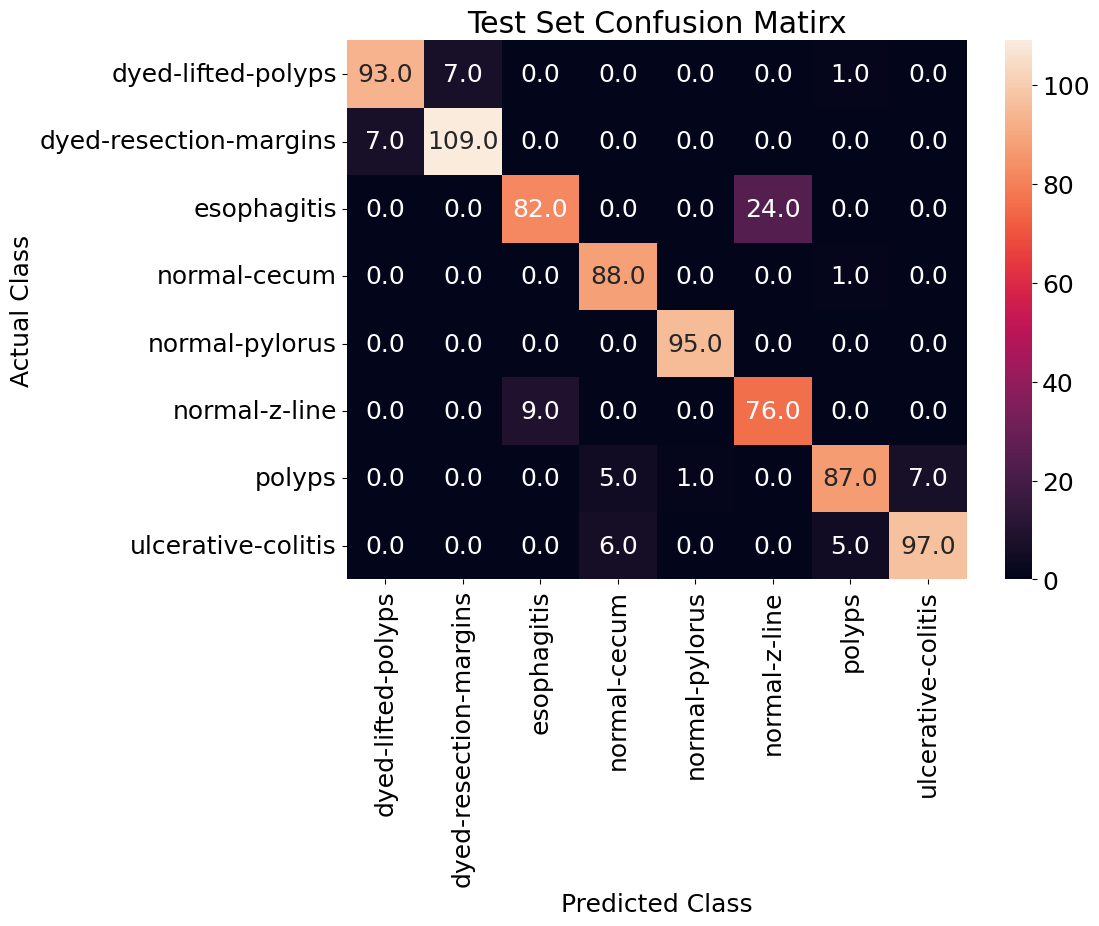

In [312]:
plt.figure(figsize=(10,7))
sns.heatmap(cm_test,annot=True,xticklabels=cls_names,yticklabels=cls_names,fmt=".1f")
plt.title('Test Set Confusion Matirx')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.savefig('confusion matrix test1.png')
plt.show()

In [176]:
yv_pred=np.argmax(m.predict(x_val),axis=1)
yv_true=np.argmax(y_val,axis=1)

57/57 [==============================] - 1s 23ms/step


In [177]:
cm_val=confusion_matrix(yv_true,yv_pred)
cm_val

array([[212,  18,   0,   0,   0,   0,   4,   1],
       [ 12, 196,   0,   0,   0,   0,   0,   0],
       [  0,   0, 182,   0,   0,  69,   0,   1],
       [  0,   0,   0, 220,   0,   0,   3,   7],
       [  0,   0,   0,   0, 210,   2,   0,   1],
       [  0,   0,  31,   0,   1, 181,   2,   0],
       [  2,   0,   0,   6,   2,   0, 210,   9],
       [  0,   0,   0,   4,   2,   0,  12, 200]])

In [300]:
print(f"VALIDATION SET")
for i in range(8):
    tp = cm_val[i, i]
    tn = np.sum(cm_val) - np.sum(cm_val[i, :]) - np.sum(cm_val[:, i]) + cm_val[i, i]
    fp = np.sum(cm_val[:, i]) - cm_val[i, i]
    fn = np.sum(cm_val[i, :]) - cm_val[i, i]
    print(f"Class {i}: TP={tp}, TN={tn}, FP={fp}, FN={fn}")

VALIDATION SET
Class 0: TP=212, TN=1551, FP=14, FN=23
Class 1: TP=196, TN=1574, FP=18, FN=12
Class 2: TP=182, TN=1517, FP=31, FN=70
Class 3: TP=220, TN=1560, FP=10, FN=10
Class 4: TP=210, TN=1582, FP=5, FN=3
Class 5: TP=181, TN=1514, FP=71, FN=34
Class 6: TP=210, TN=1550, FP=21, FN=19
Class 7: TP=200, TN=1563, FP=19, FN=18


In [178]:
print(classification_report(yv_true,yv_pred,target_names=cls_names))

                        precision    recall  f1-score   support

    dyed-lifted-polyps       0.94      0.90      0.92       235
dyed-resection-margins       0.92      0.94      0.93       208
           esophagitis       0.85      0.72      0.78       252
          normal-cecum       0.96      0.96      0.96       230
        normal-pylorus       0.98      0.99      0.98       213
         normal-z-line       0.72      0.84      0.78       215
                polyps       0.91      0.92      0.91       229
    ulcerative-colitis       0.91      0.92      0.92       218

              accuracy                           0.90      1800
             macro avg       0.90      0.90      0.90      1800
          weighted avg       0.90      0.90      0.89      1800



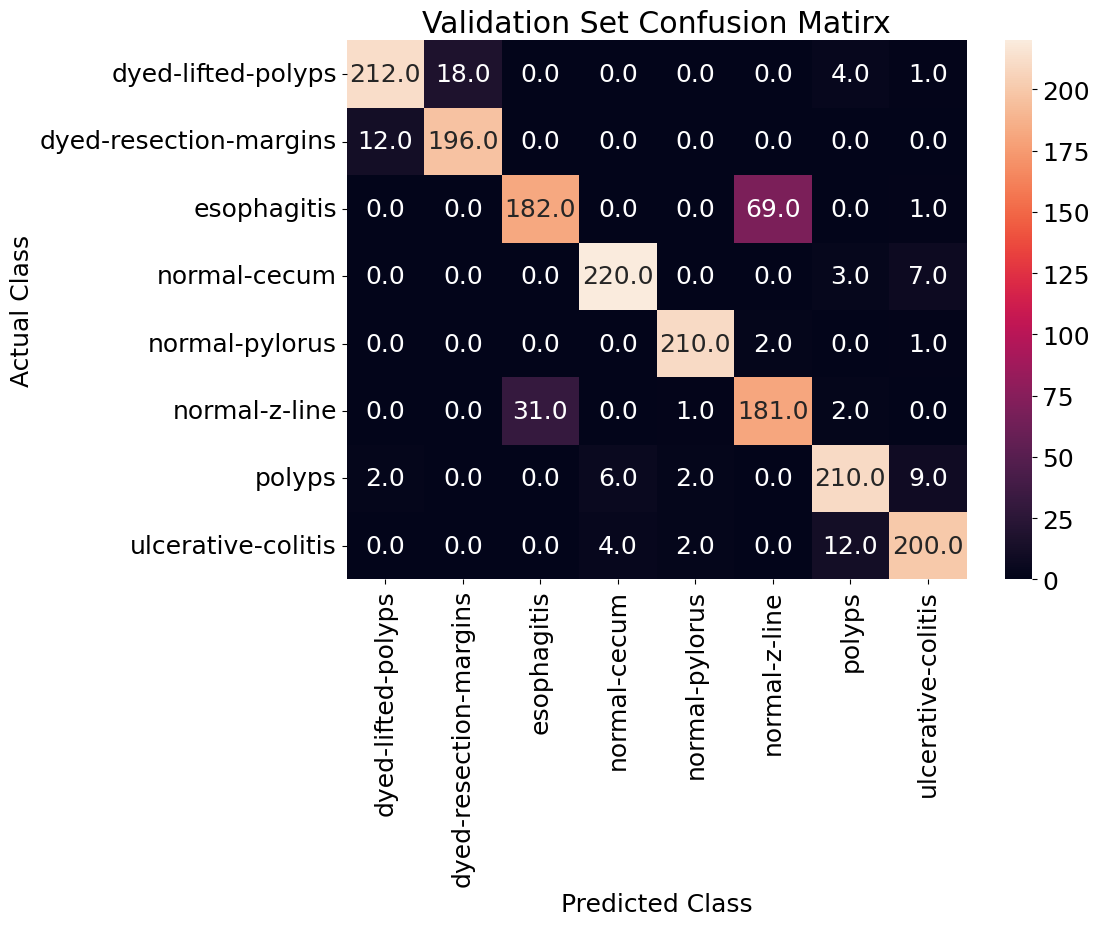

In [314]:
plt.figure(figsize=(10,7))
sns.heatmap(cm_val,annot=True,xticklabels=cls_names,yticklabels=cls_names,fmt=".1f")
plt.title('Validation Set Confusion Matirx')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.savefig('confusion matrix val1.png')
plt.show()

In [182]:
ytr_pred=np.argmax(m.predict(x_train),axis=1)
ytr_true=np.argmax(y_train,axis=1)

169/169 [==============================] - 4s 23ms/step


In [184]:
cm_train=confusion_matrix(ytr_true,ytr_pred)
cm_train

array([[663,   1,   0,   0,   0,   0,   0,   0],
       [  0, 676,   0,   0,   0,   0,   0,   0],
       [  0,   0, 642,   0,   0,   0,   0,   0],
       [  0,   0,   0, 681,   0,   0,   0,   0],
       [  0,   0,   0,   0, 692,   0,   0,   0],
       [  0,   0,   0,   0,   0, 700,   0,   0],
       [  0,   0,   0,   0,   0,   0, 671,   0],
       [  0,   0,   0,   0,   0,   0,   0, 674]])

In [185]:
print(classification_report(ytr_true,ytr_pred,target_names=cls_names))

                        precision    recall  f1-score   support

    dyed-lifted-polyps       1.00      1.00      1.00       664
dyed-resection-margins       1.00      1.00      1.00       676
           esophagitis       1.00      1.00      1.00       642
          normal-cecum       1.00      1.00      1.00       681
        normal-pylorus       1.00      1.00      1.00       692
         normal-z-line       1.00      1.00      1.00       700
                polyps       1.00      1.00      1.00       671
    ulcerative-colitis       1.00      1.00      1.00       674

              accuracy                           1.00      5400
             macro avg       1.00      1.00      1.00      5400
          weighted avg       1.00      1.00      1.00      5400



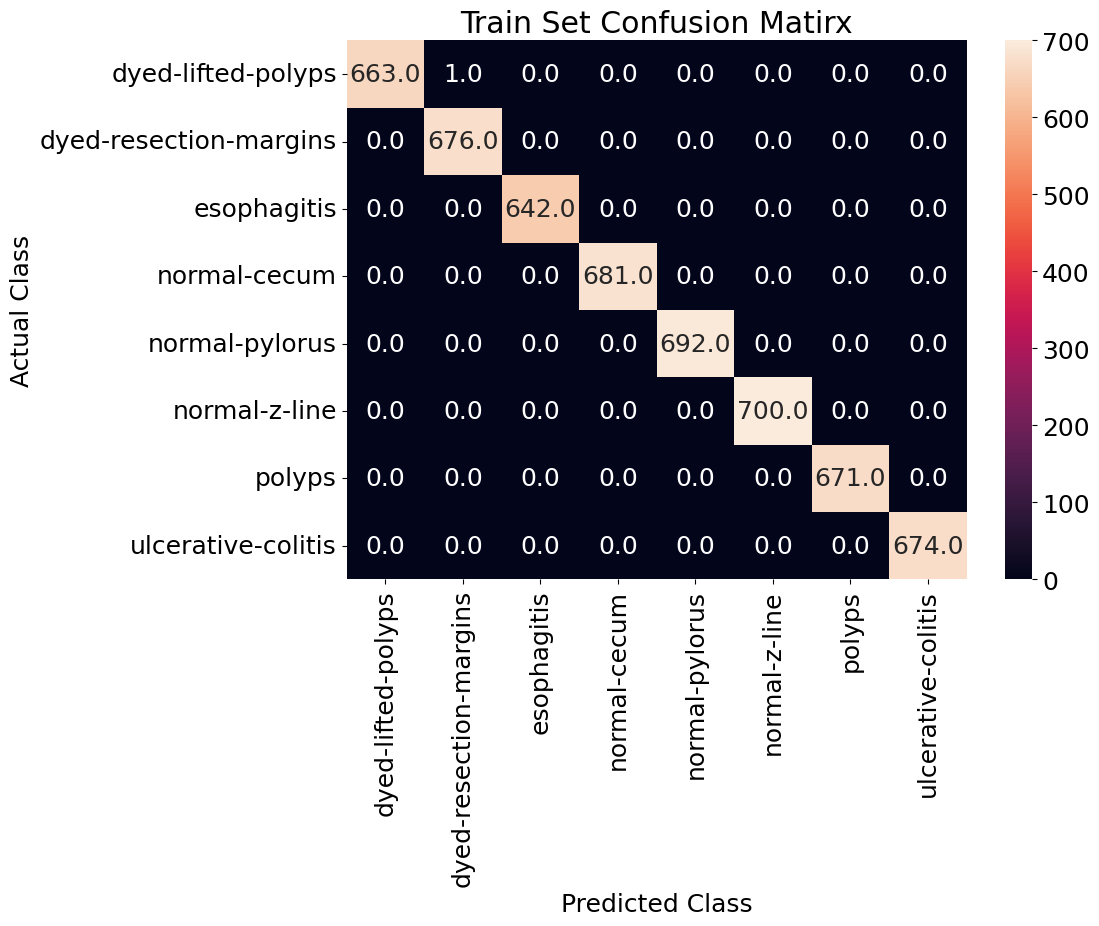

In [315]:
plt.figure(figsize=(10,7))
sns.heatmap(cm_train,annot=True,xticklabels=cls_names,yticklabels=cls_names,fmt=".1f")
plt.title('Train Set Confusion Matirx')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.savefig('confusion matrix train1.png')
plt.show()

**IMAGE-PREDICTION USING THE ABOVE MODEL**

1/1 [==============================] - 0s 18ms/step


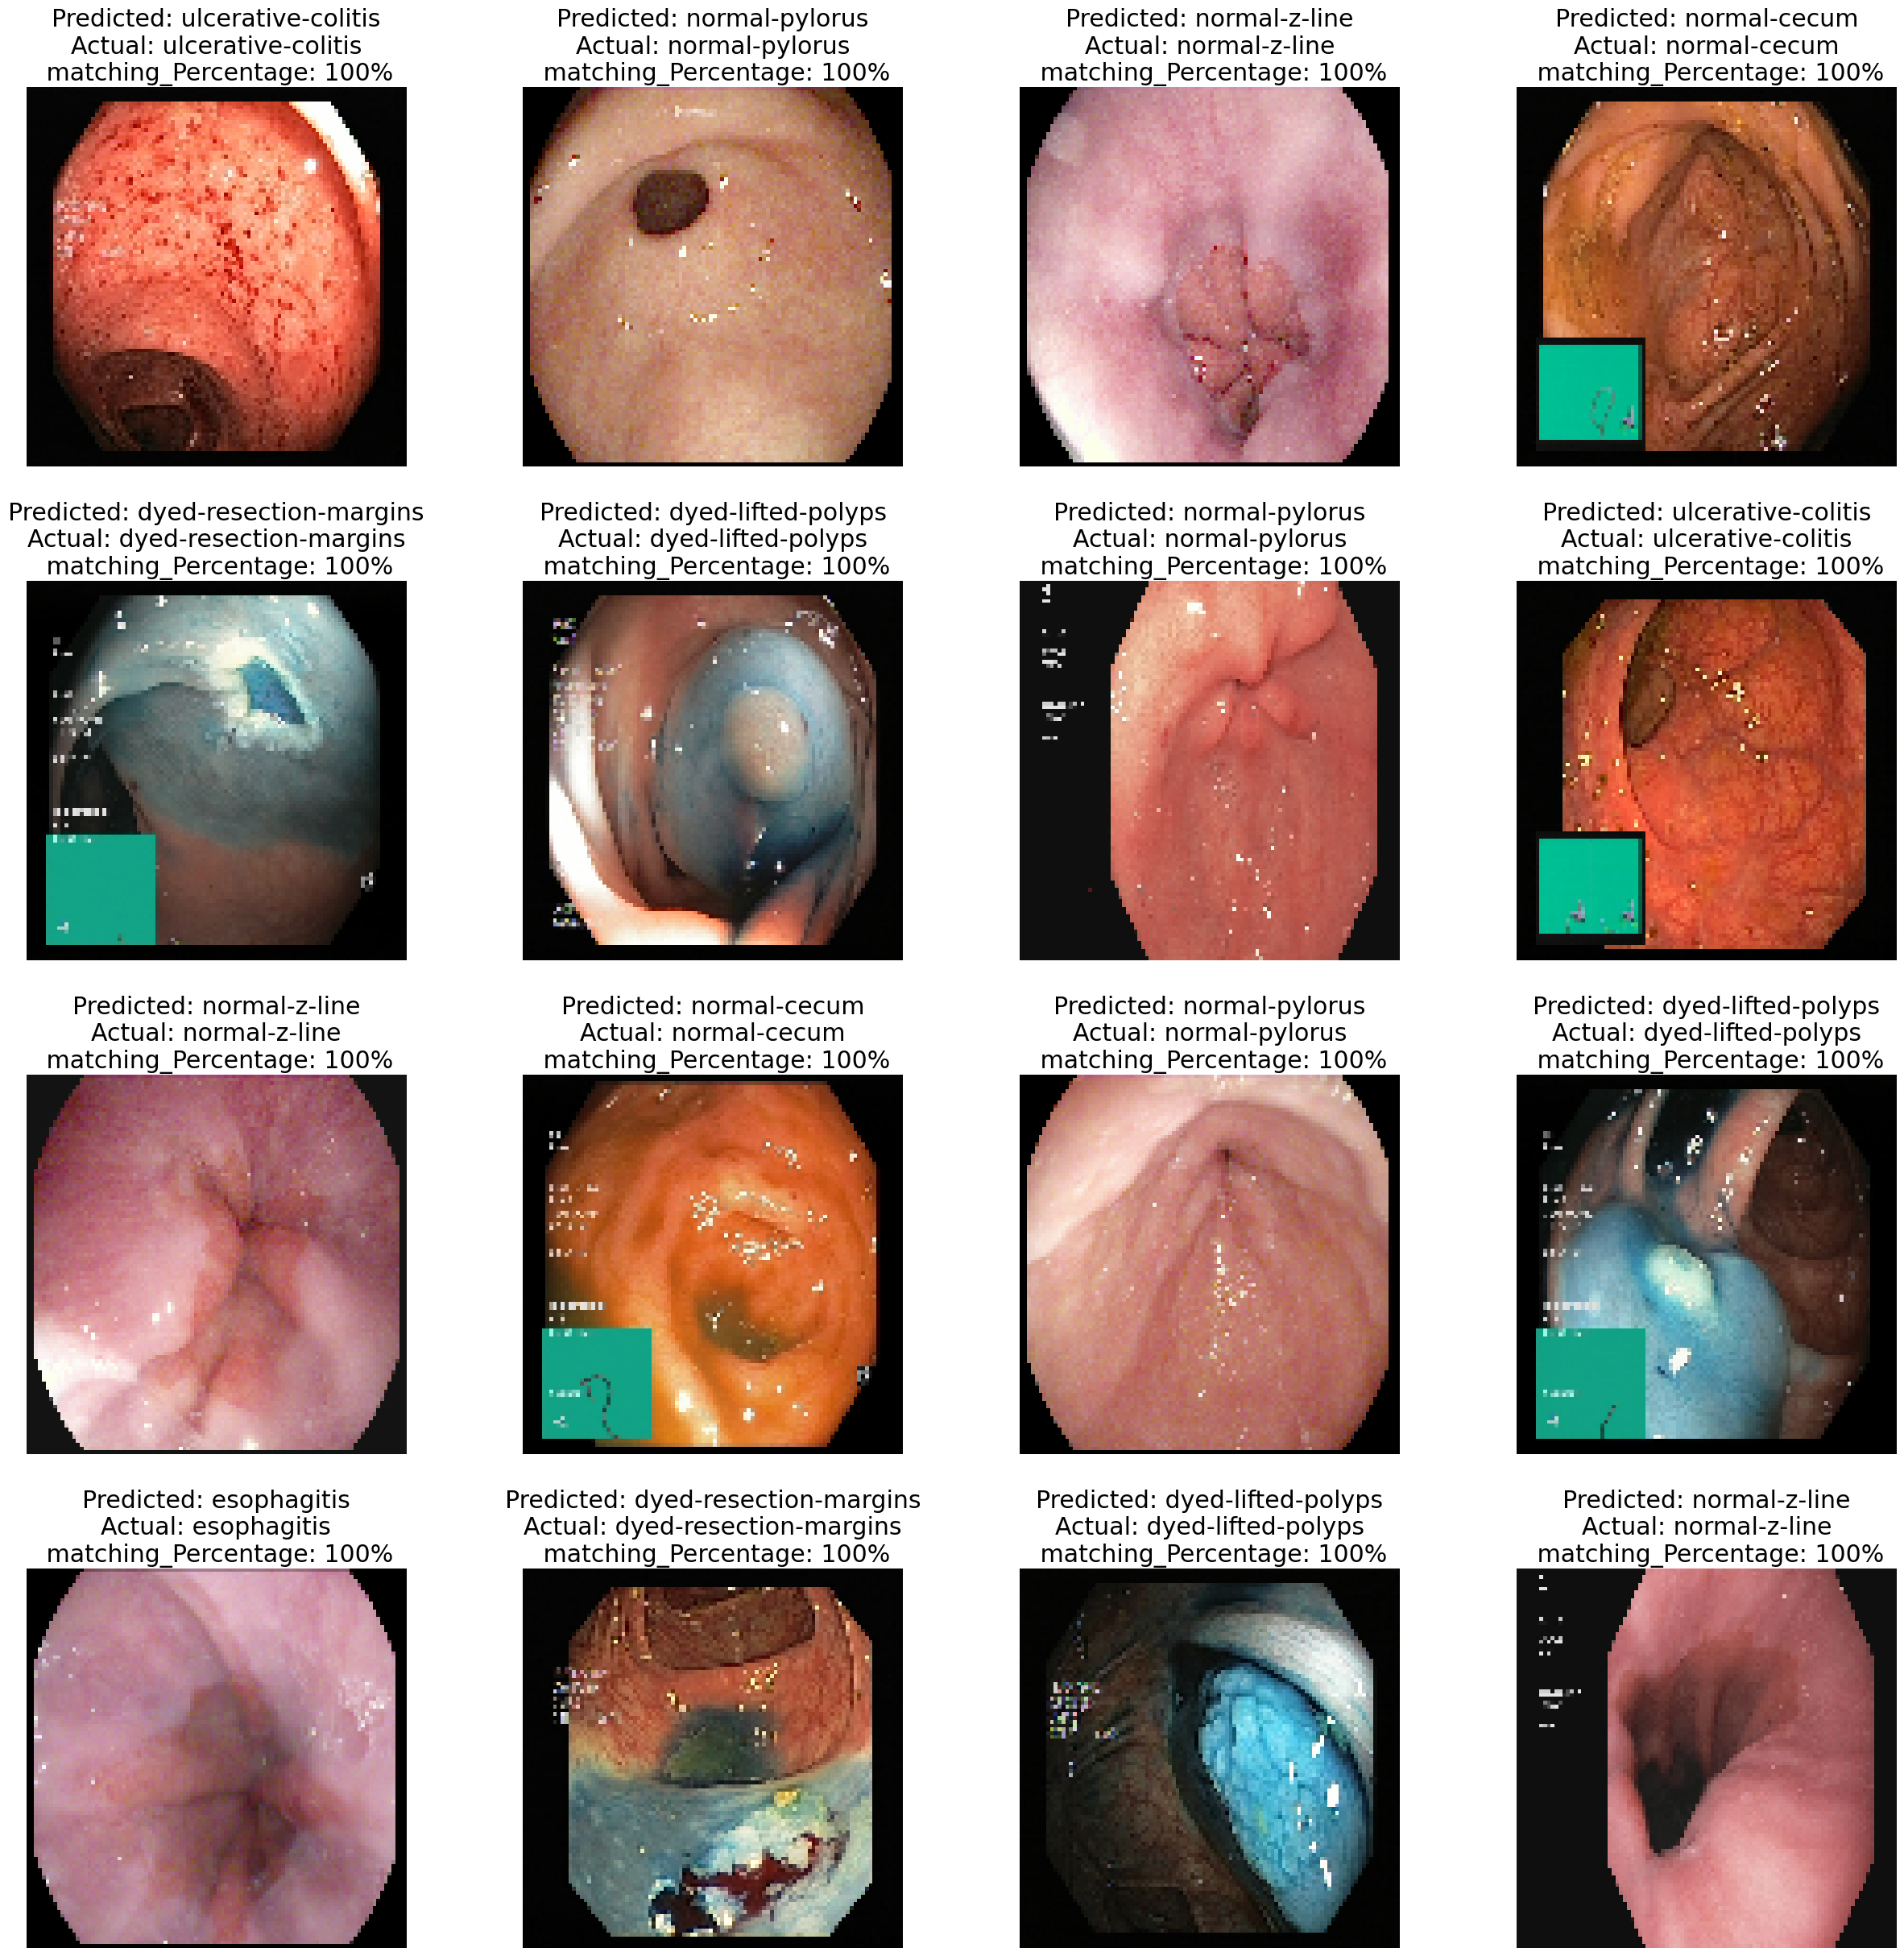

In [297]:
plt.figure(figsize=(30, 30))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
for i in range(16):
    idx = np.random.randint(len(y))
    img, true_class = x[idx], categories[y[idx].squeeze()]

    # predict class probabilities for the current image
    probs = m.predict(img[None, :, :, :])[0]
    pred_class = categories[np.argmax(probs)]
    max_prob = np.max(probs)*100
    plt.rcParams.update({'font.size':18})
    plt.subplot(4, 4, i + 1)
    plt.imshow(img[:, :, ::-1])
    plt.title(f"Predicted: {pred_class}\nActual: {true_class}\n matching_Percentage: {round(max_prob)}%")
    plt.axis("off")
plt.show()
